In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda:3"

In [3]:
transform = torchvision.transforms.Compose(
    [
       torchvision.transforms.ToTensor(),
       torchvision.transforms.Normalize(
           (0.5, 0.5, 0.5), 
           (0.5, 0.5, 0.5)
       ),
    ]
)

inverse_transform = torchvision.transforms.Compose(
    [
       torchvision.transforms.Normalize(
           (-1, -1, -1), 
           (2, 2, 2)
       ),
       torchvision.transforms.ToPILImage()
    ]
)

# 1. Pix2Pix

In [4]:
class FacadeDataset(Dataset):

    def __init__(self, path, transforms):
        super().__init__()
        self.image_pathes = list(Path(path).rglob("*.jpg"))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_pathes)

    def __getitem__(self, idx):
        path = self.image_pathes[idx]
        image = Image.open(path)
        width = image.width
        sep = width // 2
        image_array = np.array(image)
        input_image = image_array[:, sep:]
        output_image = image_array[:, :sep]
        input_image = self.transforms(input_image)
        output_image = self.transforms(output_image)
        return input_image, output_image

In [5]:
class GeneratorUNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super().__init__()

        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self._block((features * 8) * 2, features * 8)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self._block((features * 4) * 2, features * 4)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self._block((features * 2) * 2, features * 2)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = self._block(features * 2, features)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.tanh(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.InstanceNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.InstanceNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

In [6]:
generator = GeneratorUNet(3)
backbone = torchvision.models.resnet18(pretrained=False, num_classes=1, norm_layer=nn.InstanceNorm2d)

In [7]:
backbone.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
discriminator = nn.Sequential(
    backbone,
    nn.Sigmoid()
)

In [8]:
train_dataset = FacadeDataset("facades/train", transform)
test_dataset = FacadeDataset("facades/test", transform)

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
)

In [10]:
EPOCH = 10
LR_GEN = 1e-3
LR_DIS = 1e-3
LAMBDA_PIXEL = 100
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=LR_GEN)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LR_DIS)

In [11]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [12]:
for epoch in range(EPOCH):
    for i, (input_tensor, output_tensor) in enumerate(train_dataloader):

        input_tensor = input_tensor.to(device)
        output_tensor = output_tensor.to(device)
        optimizer_generator.zero_grad()
        
        discriminator.requires_grad_(False)
        generated = generator(input_tensor)
        pred_fake = discriminator(torch.cat([generated, output_tensor], dim=1))
        pred_true = discriminator(torch.cat([input_tensor, output_tensor], dim=1))


        loss_pixel = F.l1_loss(generated, output_tensor)
        loss_dis_gen = -torch.log(pred_fake).mean()
        loss_gen = loss_dis_gen + LAMBDA_PIXEL * loss_pixel
        loss_gen.backward()
        optimizer_generator.step()

        optimizer_discriminator.zero_grad()
        discriminator.requires_grad_(True)
        pred_fake = discriminator(torch.cat([generated.detach(), output_tensor], dim=1))
        loss_dis_fake = -torch.log(1 - pred_fake).mean()
        loss_dis_true = -torch.log(pred_true).mean()
        loss_dis = loss_dis_fake + loss_dis_true
        loss_dis.backward()

        optimizer_discriminator.step()

        if (i + 1) % 200 == 0:
            print(f"Epoch: {epoch + 1} / {EPOCH}, iter: {i + 1}/{len(train_dataloader)}, loss_gen: {loss_gen.item():.3f}, loss_dis: {loss_dis.item():.3f}")

Epoch: 1 / 10, iter: 200/500, loss_gen: 51.814, loss_dis: 9.169
Epoch: 1 / 10, iter: 400/500, loss_gen: 52.265, loss_dis: 9.671
Epoch: 2 / 10, iter: 200/500, loss_gen: 51.603, loss_dis: 10.070
Epoch: 2 / 10, iter: 400/500, loss_gen: 32.113, loss_dis: 11.059
Epoch: 3 / 10, iter: 200/500, loss_gen: 42.254, loss_dis: 11.413
Epoch: 3 / 10, iter: 400/500, loss_gen: 53.867, loss_dis: 11.175
Epoch: 4 / 10, iter: 200/500, loss_gen: 42.848, loss_dis: 11.970
Epoch: 4 / 10, iter: 400/500, loss_gen: 39.550, loss_dis: 11.492
Epoch: 5 / 10, iter: 200/500, loss_gen: 45.266, loss_dis: 12.425
Epoch: 5 / 10, iter: 400/500, loss_gen: 59.786, loss_dis: 12.122
Epoch: 6 / 10, iter: 200/500, loss_gen: 41.656, loss_dis: 12.314
Epoch: 6 / 10, iter: 400/500, loss_gen: 48.436, loss_dis: 12.629
Epoch: 7 / 10, iter: 200/500, loss_gen: 43.043, loss_dis: 12.961
Epoch: 7 / 10, iter: 400/500, loss_gen: 39.316, loss_dis: 12.639
Epoch: 8 / 10, iter: 200/500, loss_gen: 42.060, loss_dis: 12.986
Epoch: 8 / 10, iter: 400/50

In [13]:
images = []
for i, (input_tensor, output_tensor) in enumerate(test_dataloader):
    if i == 10:
        break
    with torch.no_grad():
        generated = generator(input_tensor.to(device)).to("cpu").squeeze(0)
        images.append(
            (
                inverse_transform(input_tensor.to("cpu").squeeze(0)), 
                inverse_transform(output_tensor.to("cpu").squeeze(0)), 
                inverse_transform(generated)
            )
        )

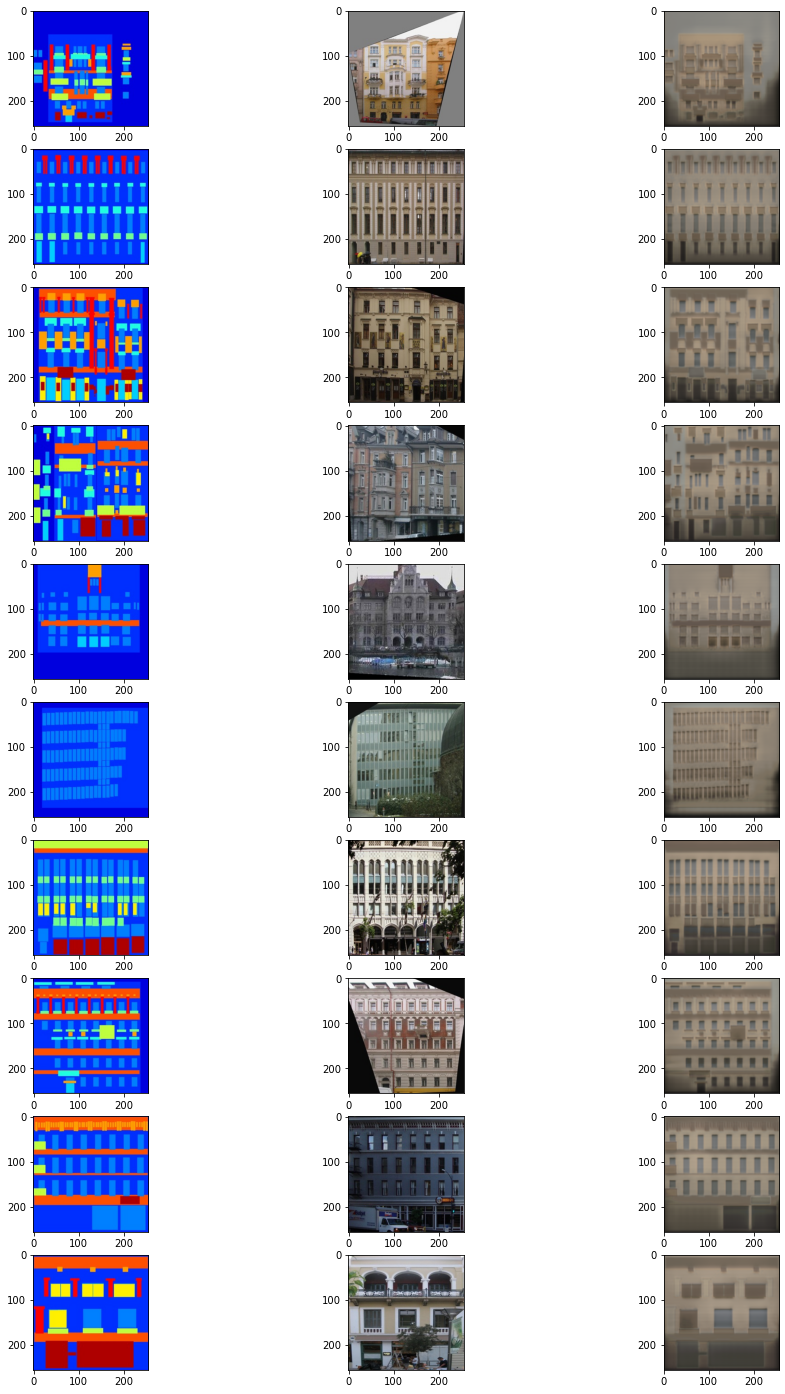

In [14]:
fig, ax = plt.subplots(10, 3)
fig.set_figwidth(16)
fig.set_figheight(25)
for i in range(10):
    ax[i, 0].imshow(np.array(images[i][0]))
    ax[i, 1].imshow(np.array(images[i][1]))
    ax[i, 2].imshow(np.array(images[i][2]))

In [15]:
class ResnetBlock(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0), 
            nn.InstanceNorm2d(dim), 
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [16]:
class ResnetGenerator(nn.Module):

    def __init__(self, input_nc, ngf=64, norm_layer=nn.BatchNorm2d, n_blocks=6):

        super().__init__()

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):

            model += [ResnetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, input_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [17]:
del generator
del discriminator
del optimizer_discriminator
del optimizer_generator

In [18]:
class FacadeDatasetCycle(Dataset):

    def __init__(self, path, transforms):
        super().__init__()
        self.image_pathes = list(Path(path).rglob("*.jpg"))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_pathes)

    def __getitem__(self, idx):
        path = self.image_pathes[idx]
        image = Image.open(path)
        width = image.width
        sep = width // 2
        image_array = np.array(image)
        mask = image_array[:, sep:]

        path = np.random.choice(self.image_pathes)
        image = Image.open(path)
        image_array = np.array(image)
        facade = image_array[:, :sep]

        mask = self.transforms(mask)
        facade = self.transforms(facade)
        return mask, facade

In [28]:
generator_facade = ResnetGenerator(3)
generator_mask = ResnetGenerator(3)

discriminator_facade = nn.Sequential(
    torchvision.models.resnet18(pretrained=False, num_classes=1, norm_layer=nn.InstanceNorm2d),
    nn.Sigmoid()
)
discriminator_mask = nn.Sequential(
    torchvision.models.resnet18(pretrained=False, num_classes=1, norm_layer=nn.InstanceNorm2d),
    nn.Sigmoid()
)

In [29]:
generator_facade = generator_facade.to(device)
generator_mask = generator_mask.to(device)
discriminator_facade = discriminator_facade.to(device)
discriminator_mask = discriminator_mask.to(device)

In [30]:
train_dataset = FacadeDatasetCycle("facades/train", transform)
test_dataset = FacadeDatasetCycle("facades/test", transform)

In [31]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
)

In [32]:
EPOCH = 100
LR_GEN = 2e-3
LR_DIS = 2e-3
LAMBDA_CONSTRUCT = 50

In [33]:
optimizer_generator_facade = torch.optim.Adam(generator_facade.parameters(), lr=LR_GEN)
optimizer_generator_mask = torch.optim.Adam(generator_mask.parameters(), lr=LR_GEN)
optimizer_discriminator_facade = torch.optim.Adam(discriminator_facade.parameters(), lr=LR_DIS)
optimizer_discriminator_mask = torch.optim.Adam(discriminator_mask.parameters(), lr=LR_DIS)

In [34]:
for epoch in range(EPOCH):
    for i, (mask, facade) in enumerate(train_dataloader):

        mask = mask.to(device)
        facade = facade.to(device)
        
        optimizer_generator_facade.zero_grad()
        optimizer_generator_mask.zero_grad()

        facade_gen = generator_facade(mask)
        mask_gen = generator_mask(facade)
        facade_recon = generator_facade(mask_gen)
        mask_recon = generator_mask(facade_gen)

        loss_facade_recon = F.l1_loss(facade_recon, facade)
        loss_mask_recon = F.l1_loss(mask_recon, mask)

        discriminator_facade.requires_grad_(False)
        discriminator_mask.requires_grad_(False)

        facade_false = discriminator_facade(facade_gen)
        mask_false = discriminator_mask(mask_gen)

        valid = torch.ones_like(mask_false).to(device)
        false = torch.zeros_like(mask_false).to(device)

        loss_dis_gen_facade = F.mse_loss(facade_false, valid)
        loss_dis_gen_mask = F.mse_loss(mask_false, valid)

        loss_gen = loss_dis_gen_facade + loss_dis_gen_mask + LAMBDA_CONSTRUCT * (loss_facade_recon + loss_mask_recon)
        loss_gen.backward()

        optimizer_generator_facade.step()
        optimizer_generator_mask.step()

        optimizer_discriminator_facade.zero_grad()
        optimizer_discriminator_mask.zero_grad()
        discriminator_facade.requires_grad_(True)
        discriminator_mask.requires_grad_(True)

        facade_true = discriminator_facade(facade)
        mask_true = discriminator_mask(mask)
        facade_false = discriminator_facade(facade_gen.detach())
        mask_false = discriminator_mask(mask_gen.detach())

        loss_dis_facade_fake = F.mse_loss(facade_false, false)
        loss_dis_facade_true = F.mse_loss(facade_true, valid)
        loss_dis_mask_fake = F.mse_loss(mask_false, false)
        loss_dis_mask_true = F.mse_loss(mask_true, valid)

        loss_dis = loss_dis_facade_fake + loss_dis_facade_true + loss_dis_mask_fake + loss_dis_mask_true
        loss_dis.backward()

        optimizer_discriminator_facade.step()
        optimizer_discriminator_mask.step()

        if (i + 1) % 200 == 0:
            print(f"Epoch: {epoch + 1} / {EPOCH}, iter: {i + 1}/{len(train_dataloader)}, loss_gen: {loss_gen.item():.3f}, loss_dis: {loss_dis.item():.3f}")

Epoch: 1 / 100, iter: 200/500, loss_gen: 33.074, loss_dis: 0.254
Epoch: 1 / 100, iter: 400/500, loss_gen: 31.481, loss_dis: 0.913
Epoch: 2 / 100, iter: 200/500, loss_gen: 20.494, loss_dis: 0.402
Epoch: 2 / 100, iter: 400/500, loss_gen: 17.549, loss_dis: 0.000
Epoch: 3 / 100, iter: 200/500, loss_gen: 20.104, loss_dis: 0.000
Epoch: 3 / 100, iter: 400/500, loss_gen: 16.446, loss_dis: 0.779
Epoch: 4 / 100, iter: 200/500, loss_gen: 21.038, loss_dis: 0.000
Epoch: 4 / 100, iter: 400/500, loss_gen: 17.343, loss_dis: 0.000
Epoch: 5 / 100, iter: 200/500, loss_gen: 20.161, loss_dis: 0.002
Epoch: 5 / 100, iter: 400/500, loss_gen: 17.355, loss_dis: 0.000
Epoch: 6 / 100, iter: 200/500, loss_gen: 19.662, loss_dis: 0.000
Epoch: 6 / 100, iter: 400/500, loss_gen: 13.484, loss_dis: 0.000
Epoch: 7 / 100, iter: 200/500, loss_gen: 13.998, loss_dis: 0.000
Epoch: 7 / 100, iter: 400/500, loss_gen: 15.938, loss_dis: 0.000
Epoch: 8 / 100, iter: 200/500, loss_gen: 16.741, loss_dis: 0.000
Epoch: 8 / 100, iter: 400

In [35]:
images = []
for i, (mask, facade) in enumerate(test_dataloader):
    if i == 10:
        break
    with torch.no_grad():
        generated_facade = generator_facade(mask.to(device)).to("cpu").squeeze(0)
        generated_mask = generator_mask(facade.to(device)).to("cpu").squeeze(0)
        images.append(
            (
                inverse_transform(mask.to("cpu").squeeze(0)), 
                inverse_transform(facade.to("cpu").squeeze(0)), 
                inverse_transform(generated_mask),
                inverse_transform(generated_facade)
            )
        )

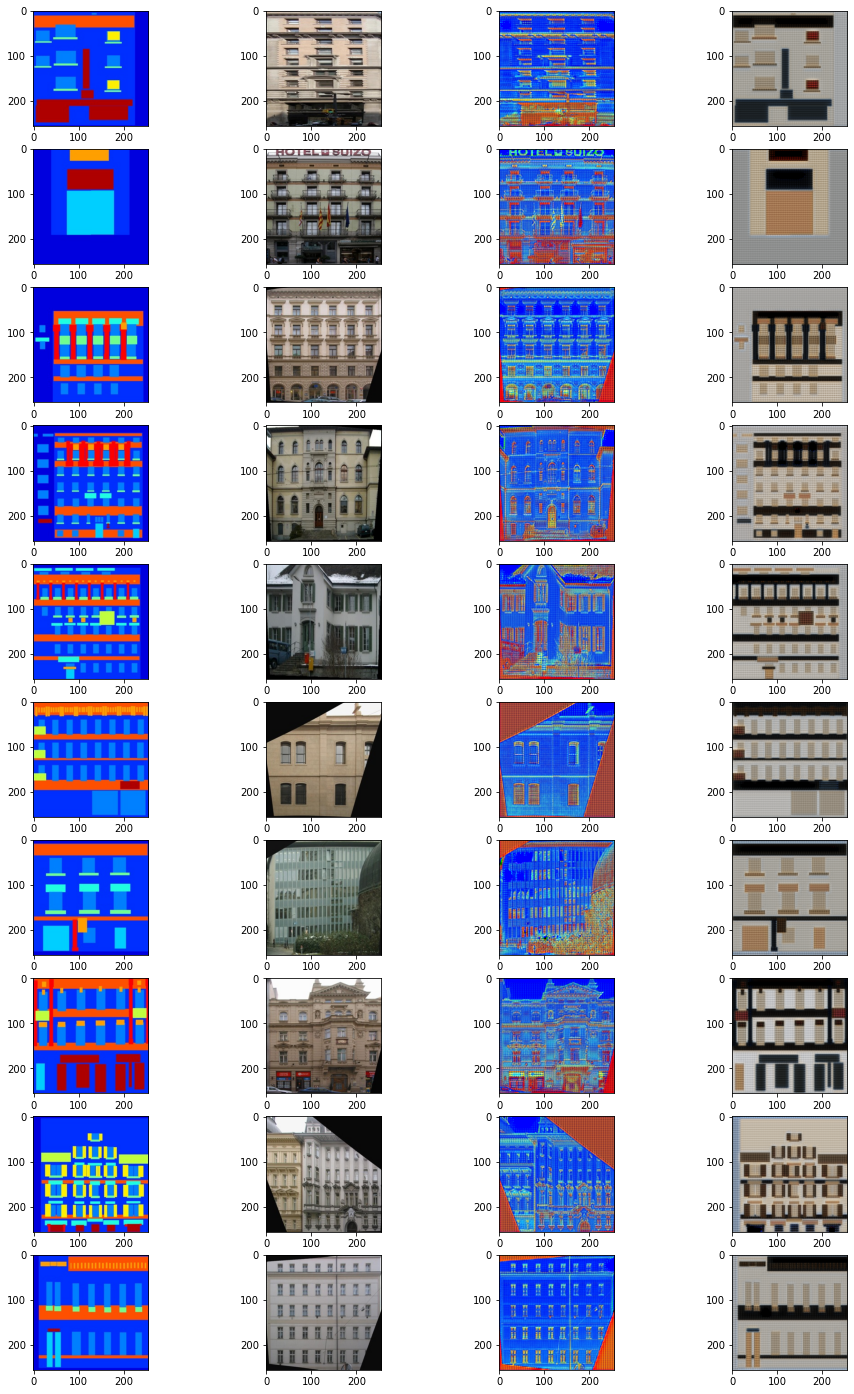

In [36]:
fig, ax = plt.subplots(10, 4)
fig.set_figwidth(16)
fig.set_figheight(25)
for i in range(10):
    ax[i, 0].imshow(np.array(images[i][0]))
    ax[i, 1].imshow(np.array(images[i][1]))
    ax[i, 2].imshow(np.array(images[i][2]))
    ax[i, 3].imshow(np.array(images[i][3]))